In [1]:
from line_profiler import LineProfiler
import numpy as np
from math import pi, ceil, factorial
import matplotlib.pyplot as plt

plt.style.use('seaborn')
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 15

legend_opts = {
    'fontsize':15,
    'frameon':True, 
    'framealpha':1,
    'facecolor':'white',
    'edgecolor':'black',
    'labelspacing':0.1}

def savefig(fig, filename, **kwargs):
    fig.savefig(f'../viz/{filename}', bbox_inches='tight', **kwargs)

/tmp/ipykernel_102/3102136420.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
def extract_milisecs(profile, n_trials):
    stats = profile.get_stats()
    timings = list(stats.timings.values())[0]
    milisecs = [time * stats.unit * 1000 / n_trials for line, hit, time in timings]
    return milisecs

In [3]:
n_trials = 100
n_samples = 1000000

In [4]:
profile_box = LineProfiler()
@profile_box
def generate_box(n_samples):
    # 0. Generate U1's and U2's, which are Unif(0, 1)
    rng = np.random.RandomState(seed=42)
    u1s, u2s = rng.uniform(size=n_samples), rng.uniform(size=n_samples)

    # 1. Transform U1 to cos & sin of thetas
    thetas = 2*pi*u1s
    cos_thetas, sin_thetas = np.cos(thetas), np.sin(thetas)

    # 2. Tranform U2 to r
    ss = -np.log(u2s)
    rs = np.sqrt(2*ss)

    # 3. Calculate x and y from r and cos & sin of thetas
    xs, ys = rs*cos_thetas, rs*sin_thetas
    
    # 4. Return xs and ys
    return xs, ys

for _ in range(n_trials):
    xs_box, ys_box = generate_box(n_samples)
timings_box = extract_milisecs(profile_box, n_trials)
print(f'Total ms per trial: {sum(timings_box)}')
profile_box.print_stats(output_unit=1e-3)

Total ms per trial: 57.41752885999999
Timer unit: 0.001 s

Total time: 5.74175 s
File: /tmp/ipykernel_102/2991230937.py
Function: generate_box at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
     2                                           @profile_box
     3                                           def generate_box(n_samples):
     4                                               # 0. Generate U1's and U2's, which are Unif(0, 1)
     5       100         33.5      0.3      0.6      rng = np.random.RandomState(seed=42)
     6       100       3549.9     35.5     61.8      u1s, u2s = rng.uniform(size=n_samples), rng.uniform(size=n_samples)
     7                                           
     8                                               # 1. Transform U1 to cos & sin of thetas
     9       100        141.7      1.4      2.5      thetas = 2*pi*u1s
    10       100        622.5      6.2     10.8      cos_thetas, sin_thetas = np.cos(thetas), np.sin(thetas)
    1

In [5]:
profile_neumann = LineProfiler()
@profile_neumann
def generate_neumann(n_samples):
    rng = np.random.RandomState(seed=42)
    us, vs = rng.uniform(size=ceil(n_samples*4/pi)), rng.uniform(size=ceil(n_samples*4/pi))

    us, vs = 2*us - 1, 2*vs - 1
    ts = us**2 + vs**2
    is_unit_circle = ts < 1
    us, vs, ts = us[is_unit_circle], vs[is_unit_circle], ts[is_unit_circle]

    cos_thetas, sin_thetas = us / np.sqrt(ts), vs / np.sqrt(ts)

    ws = rng.uniform(size=len(us))
    ss = -np.log(ws)
    rs = np.sqrt(2*ss)

    xs, ys = rs*cos_thetas, rs*sin_thetas
    return xs, ys

for _ in range(n_trials):
    xs_neumann, ys_neumann = generate_neumann(n_samples)
timings_neumann = extract_milisecs(profile_neumann, n_trials)
print(f'Total ms per trial: {sum(timings_neumann)}')
profile_neumann.print_stats(output_unit=1e-3)

Total ms per trial: 98.96448263
Timer unit: 0.001 s

Total time: 9.89645 s
File: /tmp/ipykernel_102/3852917176.py
Function: generate_neumann at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
     2                                           @profile_neumann
     3                                           def generate_neumann(n_samples):
     4       100         41.9      0.4      0.4      rng = np.random.RandomState(seed=42)
     5       100       3534.2     35.3     35.7      us, vs = rng.uniform(size=ceil(n_samples*4/pi)), rng.uniform(size=ceil(n_samples*4/pi))
     6                                           
     7       100        627.4      6.3      6.3      us, vs = 2*us - 1, 2*vs - 1
     8       100        463.2      4.6      4.7      ts = us**2 + vs**2
     9       100         87.0      0.9      0.9      is_unit_circle = ts < 1
    10       100       1894.9     18.9     19.1      us, vs, ts = us[is_unit_circle], vs[is_unit_circle], ts[is_unit_circle]
 

In [6]:
profile_neumann_sqrt = LineProfiler()
@profile_neumann_sqrt
def generate_neumann_sqrt(n_samples):
    rng = np.random.RandomState(seed=42)
    us, vs = rng.uniform(size=ceil(n_samples*4/pi)), rng.uniform(size=ceil(n_samples*4/pi))

    us, vs = 2*us - 1, 2*vs - 1
    ts = us**2 + vs**2
    is_unit_circle = ts < 1
    us, vs, ts = us[is_unit_circle], vs[is_unit_circle], ts[is_unit_circle]

    ws = rng.uniform(size=len(us))
    ss = -np.log(ws)

    sqrts = np.sqrt(2*ss/ts)
    xs, ys = us*sqrts, vs*sqrts
    return xs, ys

for _ in range(n_trials):
    xs_neumann_sqrt, ys_neumann_sqrt = generate_neumann_sqrt(n_samples)
timings_neumann_sqrt = extract_milisecs(profile_neumann_sqrt, n_trials)
print(f'Total ms per trial: {sum(timings_neumann_sqrt)}')
profile_neumann_sqrt.print_stats(output_unit=1e-3)

Total ms per trial: 88.64854566000001
Timer unit: 0.001 s

Total time: 8.86485 s
File: /tmp/ipykernel_102/1868427609.py
Function: generate_neumann_sqrt at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
     2                                           @profile_neumann_sqrt
     3                                           def generate_neumann_sqrt(n_samples):
     4       100         35.9      0.4      0.4      rng = np.random.RandomState(seed=42)
     5       100       3526.1     35.3     39.8      us, vs = rng.uniform(size=ceil(n_samples*4/pi)), rng.uniform(size=ceil(n_samples*4/pi))
     6                                           
     7       100        568.6      5.7      6.4      us, vs = 2*us - 1, 2*vs - 1
     8       100        478.2      4.8      5.4      ts = us**2 + vs**2
     9       100         91.2      0.9      1.0      is_unit_circle = ts < 1
    10       100       1797.4     18.0     20.3      us, vs, ts = us[is_unit_circle], vs[is_unit_circle],

In [7]:
profile_marsaglia = LineProfiler()
@profile_marsaglia
def generate_marsaglia(n_samples):
    rng = np.random.RandomState(seed=42)
    us, vs = rng.uniform(size=ceil(n_samples*4/pi)), rng.uniform(size=ceil(n_samples*4/pi))

    us, vs = 2*us - 1, 2*vs - 1
    ts = us**2 + vs**2
    is_unit_circle = ts < 1
    us, vs, ts = us[is_unit_circle], vs[is_unit_circle], ts[is_unit_circle]

    ss = -np.log(ts)

    sqrts = np.sqrt(2*ss/ts)
    xs, ys = us*sqrts, vs*sqrts
    return xs, ys

for _ in range(n_trials):
    xs_marsaglia, ys_marsaglia = generate_marsaglia(n_samples)
timings_marsaglia = extract_milisecs(profile_marsaglia, n_trials)
print(f'Total ms per trial: {sum(timings_marsaglia)}')
profile_marsaglia.print_stats(output_unit=1e-3)

Total ms per trial: 74.61357806000001
Timer unit: 0.001 s

Total time: 7.46136 s
File: /tmp/ipykernel_102/681170869.py
Function: generate_marsaglia at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
     2                                           @profile_marsaglia
     3                                           def generate_marsaglia(n_samples):
     4       100         36.5      0.4      0.5      rng = np.random.RandomState(seed=42)
     5       100       3539.0     35.4     47.4      us, vs = rng.uniform(size=ceil(n_samples*4/pi)), rng.uniform(size=ceil(n_samples*4/pi))
     6                                           
     7       100        556.7      5.6      7.5      us, vs = 2*us - 1, 2*vs - 1
     8       100        470.1      4.7      6.3      ts = us**2 + vs**2
     9       100         88.5      0.9      1.2      is_unit_circle = ts < 1
    10       100       1832.8     18.3     24.6      us, vs, ts = us[is_unit_circle], vs[is_unit_circle], ts[is_uni

In [14]:
profile_box_taylor = LineProfiler()
@profile_box_taylor
def generate_box_taylor(n_samples, n_degrees=5):
    # 0. Generate U1's and U2's, which are Unif(0, 1)
    rng = np.random.RandomState(seed=42)
    u1s, u2s = rng.uniform(size=n_samples), rng.uniform(size=n_samples)

    # 1. Transform U1 to cos & sin of thetas
    thetas = 2*pi*u1s
    signs = []
    even_degrees, odd_degrees = [], []
    even_factorials, odd_factorials = [], []
    for index, degree in enumerate(range(0, n_degrees, 2)):
        sign = 1 if index % 2 == 0 else -1
        signs.append(sign)
        even_degrees.append(degree)
        even_factorials.append(factorial(degree))
        odd_degrees.append(degree+1)
        odd_factorials.append(factorial(degree+1))

    cos_thetas = (signs * thetas.reshape(-1, 1)**even_degrees / even_factorials).sum(axis=1)
    sin_thetas = (signs * thetas.reshape(-1, 1)**odd_degrees / odd_factorials).sum(axis=1)

    # 2. Tranform U2 to r
    ss = -np.log(u2s)
    rs = np.sqrt(2*ss)

    # 3. Calculate x and y from r and cos & sin of thetas
    xs, ys = rs*cos_thetas, rs*sin_thetas
    
    # 4. Return xs and ys
    return xs, ys

for _ in range(n_trials):
    xs_box_taylor, ys_box_taylor = generate_box_taylor(n_samples, n_degrees=19)
timings_box_taylor = extract_milisecs(profile_box_taylor, n_trials)
print(f'Total ms per trial: {sum(timings_box_taylor) }')
profile_box_taylor.print_stats(output_unit=1e-3)

Total ms per trial: 1281.7517417400002
Timer unit: 0.001 s

Total time: 128.175 s
File: /tmp/ipykernel_102/3695968119.py
Function: generate_box_taylor at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
     2                                           @profile_box_taylor
     3                                           def generate_box_taylor(n_samples, n_degrees=5):
     4                                               # 0. Generate U1's and U2's, which are Unif(0, 1)
     5       100         36.8      0.4      0.0      rng = np.random.RandomState(seed=42)
     6       100       1729.7     17.3      1.3      u1s, u2s = rng.uniform(size=n_samples), rng.uniform(size=n_samples)
     7                                           
     8                                               # 1. Transform U1 to cos & sin of thetas
     9       100        139.8      1.4      0.1      thetas = 2*pi*u1s
    10       100          0.1      0.0      0.0      signs = []
    11       10

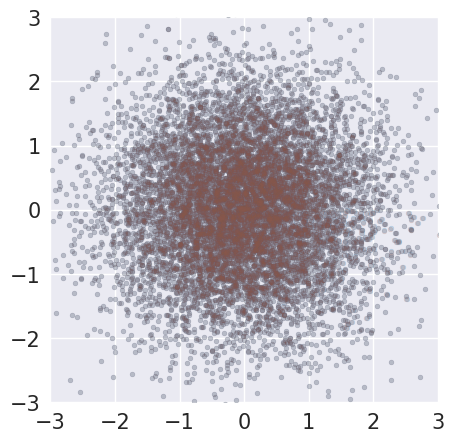

In [9]:
n_scatter = 10000
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(xs_box[:n_scatter], ys_box[:n_scatter], color='tab:blue', marker='.', alpha=0.2)
# ax.scatter(xs_neumann_sqrt[:n_scatter], ys_neumann_sqrt[:n_scatter], color='tab:gray', marker='.', alpha=0.2)
# ax.scatter(xs_neumann[:n_scatter], ys_neumann[:n_scatter], color='tab:orange', marker='.', alpha=0.2)
# ax.scatter(xs_marsaglia[:n_scatter], ys_marsaglia[:n_scatter], color='tab:red', marker='.', alpha=0.2)
ax.scatter(xs_box_taylor[:n_scatter], ys_box_taylor[:n_scatter], color='tab:brown', marker='.', alpha=0.2)

ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)

plt.show()

In [10]:
n_samples = 1000000
n_degrees = 19
rng = np.random.RandomState(seed=42)
u1s, u2s = rng.uniform(size=n_samples), rng.uniform(size=n_samples)
thetas = 2*pi*u1s
thetas

array([2.35330497, 5.97351416, 4.59925358, ..., 2.62682373, 2.69342094,
       5.83989746])

In [11]:
cos_thetas, sin_thetas = np.ones(len(thetas)), thetas.copy()

for index, degree in enumerate(range(2, n_degrees, 2)):
    sign = -1 if index % 2 == 0 else 1
    cos_thetas += sign * thetas**degree / factorial(degree)
    sin_thetas += sign * thetas**(degree+1) / factorial(degree+1)
    print(index, degree, degree+1, sign * thetas**degree / factorial(degree))

sin_thetas

0 2 3 [ -2.76902214 -17.84143572 -10.57656675 ...  -3.45010147  -3.62725818
 -17.05220117]
1 4 5 [ 1.27791394 53.05280475 18.64396069 ...  1.98386669  2.19283366
 48.46292745]
2 6 7 [ -0.2359048  -63.10254704 -13.14593965 ...  -0.45630276  -0.53026492
 -55.09330588]
3 8 9 [2.33294863e-02 4.02085727e+01 4.96567529e+00 ... 5.62246720e-02
 6.86931349e-02 3.35522191e+01]
4 10 11 [-1.43555253e-03 -1.59417481e+01 -1.16710658e+00 ... -4.31068496e-03
 -5.53706080e-03 -1.27142042e+01]
5 12 13 [6.02284357e-05 4.30944961e+00 1.87030010e-01 ... 2.25337887e-04
 3.04308319e-04 3.28492679e+00]
6 14 15 [-1.83267992e-06 -8.44909541e-01 -2.17377515e-02 ... -8.54328102e-06
 -1.21297235e-05 -6.15552005e-01]
7 16 17 [4.22894273e-08 1.25619994e-01 1.91592316e-03 ... 2.45626553e-07
 3.66646992e-07 8.74709718e-02]
8 18 19 [-7.65361834e-10 -1.46486343e-02 -1.32443720e-04 ... -5.53880086e-09
 -8.69230916e-09 -9.74884057e-03]


array([ 0.70914702, -0.30511069, -0.99360856, ...,  0.49233373,
        0.43331853, -0.42913965])

In [12]:
signs = []
even_degrees, odd_degrees = [], []
even_factorials, odd_factorials = [], []
for index, degree in enumerate(range(0, n_degrees, 2)):
    sign = 1 if index % 2 == 0 else -1
    signs.append(sign)
    even_degrees.append(degree)
    even_factorials.append(factorial(degree))
    odd_degrees.append(degree+1)
    odd_factorials.append(factorial(degree+1))

cos_thetas = (signs * thetas.reshape(-1, 1)**even_degrees / even_factorials).sum(axis=1)
sin_thetas = (signs * thetas.reshape(-1, 1)**odd_degrees / odd_factorials).sum(axis=1)

(-3.0, 3.0)

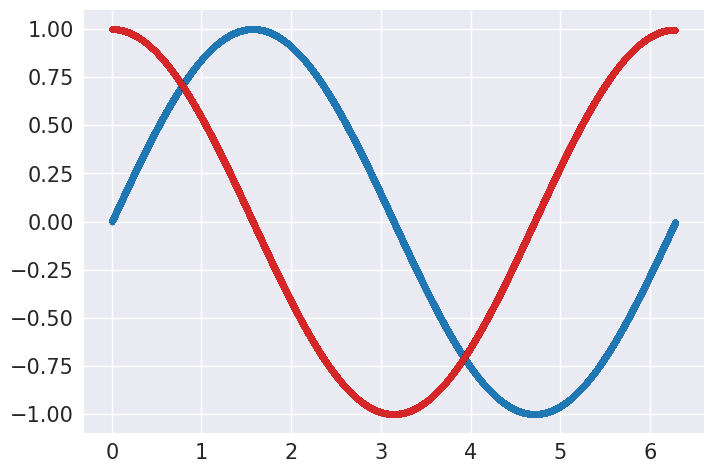

In [13]:
plt.scatter(thetas, sin_thetas, color='tab:blue', marker='.', alpha=0.2)
plt.scatter(thetas, cos_thetas, color='tab:red', marker='.', alpha=0.2)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4e503c8f-0965-423a-a3ea-3c5fc4b3d7b6' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>